In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from ema_workbench import (Model, RealParameter, ScalarOutcome)
from ema_workbench import MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim, dimensional_stacking

In [10]:
experiments, outcomes = load_results('./data/results.tar.gz')

In [11]:
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

In [12]:
outcomes_focus = outcomes.drop(columns = ['Expected Annual Damage', 'Total Investment Costs'])

In [13]:
results = pd.concat([experiments, outcomes], axis = 1)

In [14]:
uncertainties = experiments.iloc[:, :19]
levers = experiments.iloc[:, 19:50]

In [15]:
X = uncertainties
y = outcomes_focus['Expected Number of Deaths']

In [16]:
a = y.quantile(0.85)
Y = (y > a).astype(int).values

In [17]:
ema_logging.log_to_stderr(ema_logging.INFO)

prim_algorithm = prim.Prim(X, Y, threshold = 0.75)
box1 = prim_algorithm.find_box()

[MainProcess/INFO] 1000 points remaining, containing 150 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.096, coverage: 0.64, density: 1.0 restricted_dimensions: 3


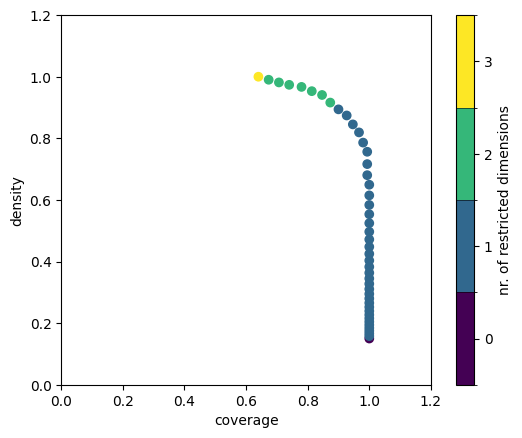

In [18]:
box1.show_tradeoff()
plt.show()

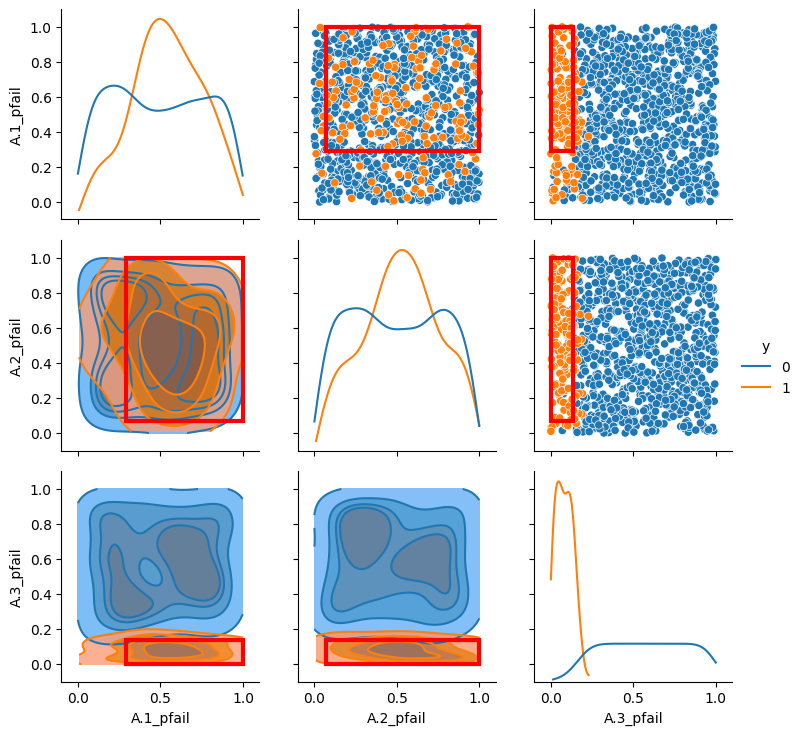

In [19]:
box1.show_pairs_scatter()
plt.show()

In [20]:
scenarios_of_interest = box1.peeling_trajectory
scenarios_of_interest = scenarios_of_interest[(scenarios_of_interest.coverage > 0.7) & (scenarios_of_interest.density > 0.8)]

The main focus of the client is to prevent casualties. Therefore it is important to have a high coverage as you don't want to miss scenario's with a high expected amount of casualties. It is less precise but more certain that all high casualty scenario's are captured in the box. Coverage above 0.9, therefore we loosen density restrictions to 0.5.

In [21]:
scenarios_of_interest = scenarios_of_interest.sort_values(by='coverage', ascending=False)
scenarios_of_interest

,coverage,density,id,k,mass,mean,n,res_dim
33,0.966667,0.819209,33,145,0.177,0.819209,177,1
34,0.946667,0.845238,34,142,0.168,0.845238,168,1
35,0.926667,0.874214,35,139,0.159,0.874214,159,1
36,0.900000,0.894040,36,135,0.151,0.894040,151,1
37,0.873333,0.916084,37,131,0.143,0.916084,143,2
38,0.846667,0.940741,38,127,0.135,0.940741,135,2
39,0.813333,0.953125,39,122,0.128,0.953125,128,2
40,0.780000,0.966942,40,117,0.121,0.966942,121,2
41,0.740000,0.973684,41,111,0.114,0.973684,114,2
42,0.706667,0.981481,42,106,0.108,0.981481,108,2


In [22]:
chosen_box = scenarios_of_interest[scenarios_of_interest['id'] == 36]
chosen_box_id = 36

In [23]:
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.282136,"{1.0, 10.0, 1.5}",0.000417,30.188923,"{1.5, 10.0, 1.0}",0.000974,30.105787,"{1.0, 10.0, 1.5}",0.000264,30.318221,"{1.5, 10.0, 1.0}",0.000287,30.224069,"{1.5, 10.0, 1.0}",0.000218,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.875601,"{1.0, 10.0, 1.5}",0.999170,349.979745,"{1.5, 10.0, 1.0}",0.999395,349.951074,"{1.0, 10.0, 1.5}",0.150569,349.726641,"{1.5, 10.0, 1.0}",0.999211,349.700927,"{1.5, 10.0, 1.0}",0.999236,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [24]:
results_PRIM = results[
    (results['A.1_pfail'] >= limits['A.1_pfail'][0]) & (results['A.1_pfail'] <= limits['A.1_pfail'][1]) &
    (results['A.3_pfail'] >= limits['A.3_pfail'][0]) & (results['A.3_pfail'] <= limits['A.3_pfail'][1])
]

In [25]:
results_PRIM = results_PRIM.drop(columns=['policy', 'model'])
#results_box_numeric.to_csv('./data/prim_results_box.csv')

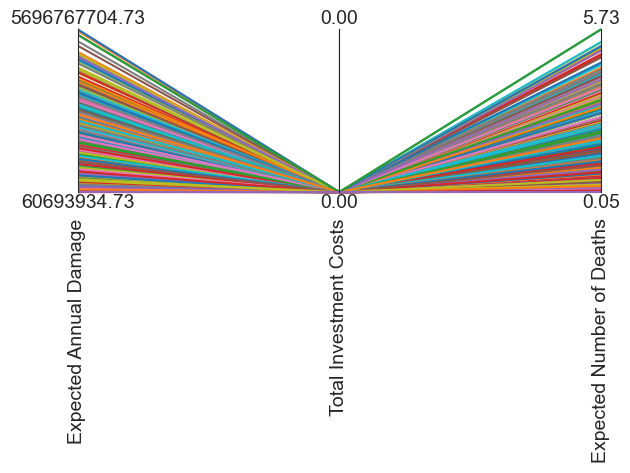

In [27]:
from ema_workbench.analysis import parcoords

data = pd.DataFrame({k:v for k,v in outcomes.items()})

indices = pd.concat([data.idxmax(), data.idxmin()]).unique()

limits = parcoords.get_limits(data)
axes = parcoords.ParallelAxes(limits)

axes.plot(data)
axes.plot(data.iloc[indices, :])
fig = plt.gcf()

plt.show()

In [28]:
print(data.idxmax())
print(data.idxmin())

Expected Annual Damage       806
Total Investment Costs         0
Expected Number of Deaths    770
dtype: int64
Expected Annual Damage       358
Total Investment Costs         0
Expected Number of Deaths    134
dtype: int64


In [29]:
selected_scenarios = experiments.loc[[458, 515, 389, 373]]
selected_scenarios = selected_scenarios.drop(columns=['policy', 'model'])

In [30]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario
458,75,126.270801,1.0,0.099493,347.265810,1.0,0.852231,116.284541,1.0,0.762816,...,0,0,0,0,0,0,0,0,0,512
515,123,78.017118,10.0,0.984748,195.503685,10.0,0.215977,245.269254,1.0,0.555007,...,0,0,0,0,0,0,0,0,0,569
389,85,55.312927,10.0,0.208733,129.715229,10.0,0.948408,69.266239,1.0,0.306357,...,0,0,0,0,0,0,0,0,0,443
373,46,287.397521,1.0,0.667717,91.037373,10.0,0.788899,315.453920,10.0,0.372474,...,0,0,0,0,0,0,0,0,0,427


In [31]:
selected_outcomes = outcomes.loc[[458, 515, 389, 373]]
selected_scenarios_outcomes = pd.concat([selected_scenarios, selected_outcomes], axis = 1)
selected_scenarios_outcomes

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
458,75,126.270801,1.0,0.099493,347.265810,1.0,0.852231,116.284541,1.0,0.762816,...,0,0,0,0,0,0,512,2.068647e+09,0.0,1.872008
515,123,78.017118,10.0,0.984748,195.503685,10.0,0.215977,245.269254,1.0,0.555007,...,0,0,0,0,0,0,569,4.168649e+08,0.0,0.365184
389,85,55.312927,10.0,0.208733,129.715229,10.0,0.948408,69.266239,1.0,0.306357,...,0,0,0,0,0,0,443,3.702513e+09,0.0,2.419925
373,46,287.397521,1.0,0.667717,91.037373,10.0,0.788899,315.453920,10.0,0.372474,...,0,0,0,0,0,0,427,4.490062e+08,0.0,0.710724


In [44]:
# The scenario column needs to be renamed to Run ID 
selected_scenarios_outcomes = selected_scenarios_outcomes.rename(columns={'scenario': 'run_id'})

In [45]:
selected_scenarios_outcomes.to_csv('./data/selected_scenarios_outcomes.csv', index=False)